In [3]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize, LinearStretch
import glob, os

# path settings
BASE_DIR = "data"

# Calibration folders
CALIB_DIR = os.path.join(BASE_DIR, "calibration")
BIAS_DIR = os.path.join(CALIB_DIR, "bias")
FLAT_DIR = os.path.join(CALIB_DIR, "flats")
MASTER_DIR = os.path.join(CALIB_DIR, "master")

# Science frames
TRANSIT_DIR = os.path.join(BASE_DIR, "raw/transit")
STANDARDS_DIR = os.path.join(BASE_DIR, "raw/standard_stars")

# Output 
OUTPUT_TRANSIT = os.path.join(BASE_DIR, "reduced/transit")
OUTPUT_STANDARDS = os.path.join(BASE_DIR, "reduced/standard_stars")

def show_fits(data, title=""):
    """
    stolen from the obs astro code but like the backend code they wrote which we didn't see
    """
    plt.figure(figsize=(8, 8))
    
    # Use ZScale for astronomical images
    interval = ZScaleInterval()
    vmin, vmax = interval.get_limits(data)
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LinearStretch())
    
    plt.imshow(data, origin='lower', cmap='gray', norm=norm)
    plt.colorbar(label='Counts')
    plt.title(title)
    print(f"{title}: min={np.min(data):.1f}, max={np.max(data):.1f}, median={np.median(data):.1f}")
    print(f"Display range (ZScale): {vmin:.1f} to {vmax:.1f}")
    plt.show()
    
trim = 50  # idk what this should be lol

Indivisual Bias Frame: min=994.0, max=2588.0, median=1051.0
Display range (ZScale): 1015.0 to 1094.0


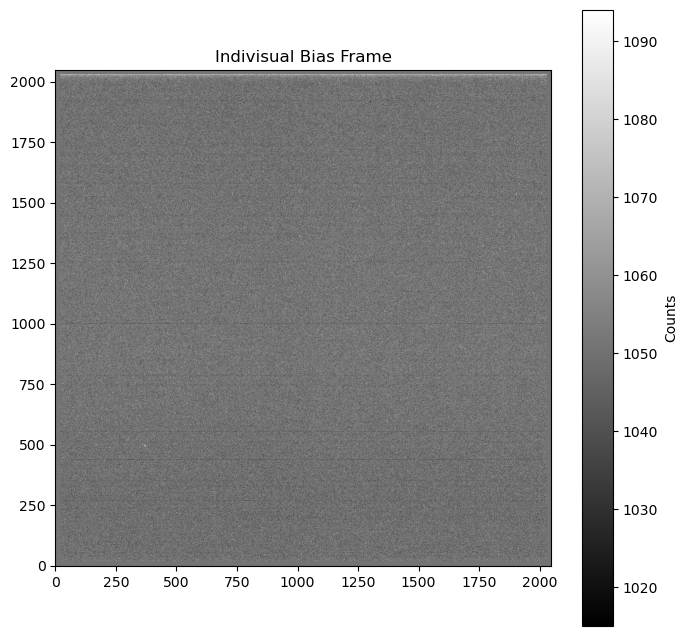

bias mean: 1051.00 ADU


In [18]:
bias = fits.getdata("data/calibration/bias/2025_09_29_bias_02.fits")

show_fits(bias, "Indivisual Bias Frame")

mean_bias = np.median(bias)

print(f"bias mean: {mean_bias:.2f} ADU")

Master Bias Frame: min=1027.5, max=1450.5, median=1049.0
Display range (ZScale): 1035.5 to 1060.5


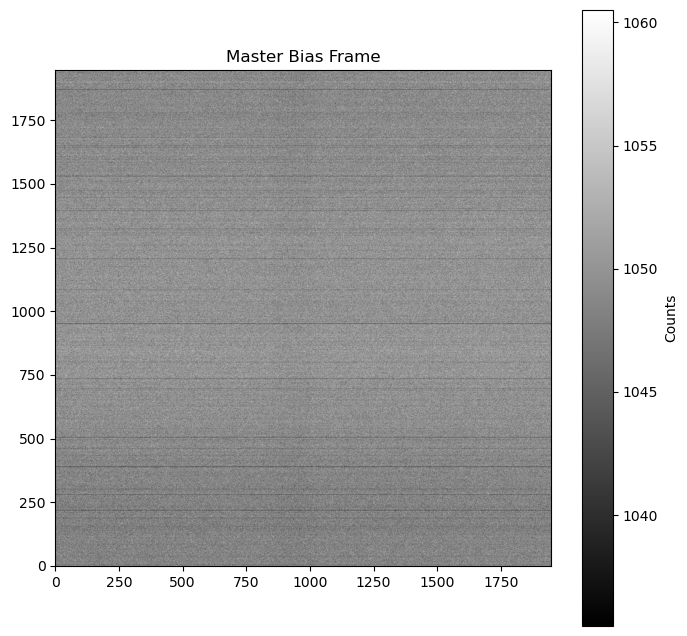

Master bias mean: 1049.19 ADU


In [ ]:
bias_files = sorted(glob.glob(os.path.join(BIAS_DIR, "*.fits")))
bias_stack = np.stack([fits.getdata(f) for f in bias_files])
master_bias = np.median(bias_stack, axis=0)

master_bias = master_bias[trim:-trim, trim:-trim]

fits.writeto(os.path.join(MASTER_DIR, "master_bias.fits"), master_bias, overwrite=True)
show_fits(master_bias, "Master Bias Frame")
print(f"Master bias mean: {np.mean(master_bias):.2f} ADU")


Detected filters: ['B', 'I', 'R', 'V']
Master Flat (B-filter): min=0.6, max=1.5, median=1.0
Display range (ZScale): 0.9 to 1.0


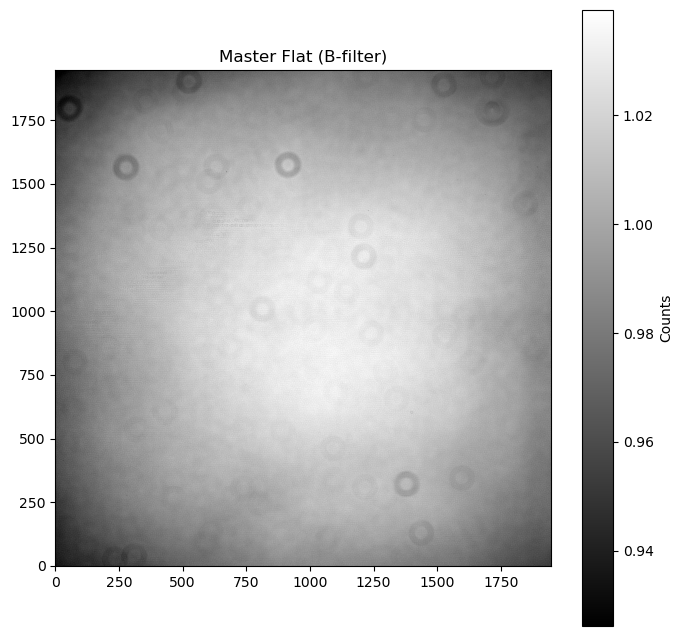

Master Flat (I-filter): min=0.7, max=3.5, median=1.0
Display range (ZScale): 0.9 to 1.0


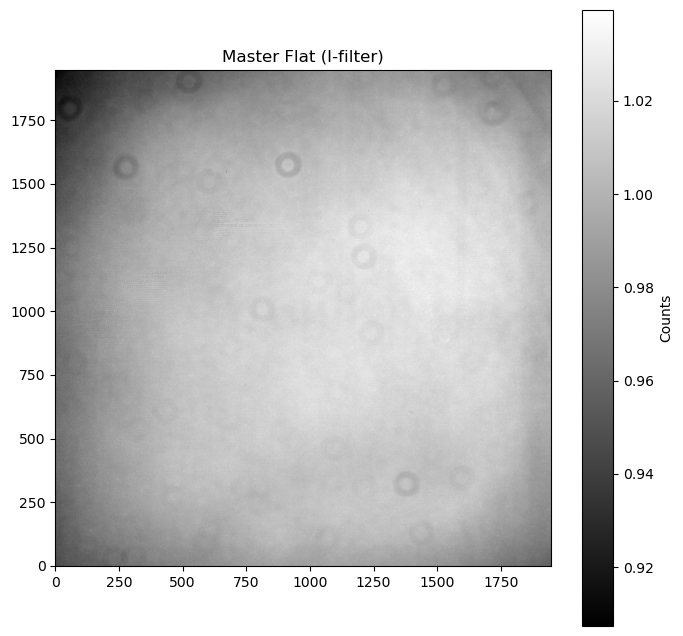

Master Flat (R-filter): min=0.7, max=2.3, median=1.0
Display range (ZScale): 0.9 to 1.0


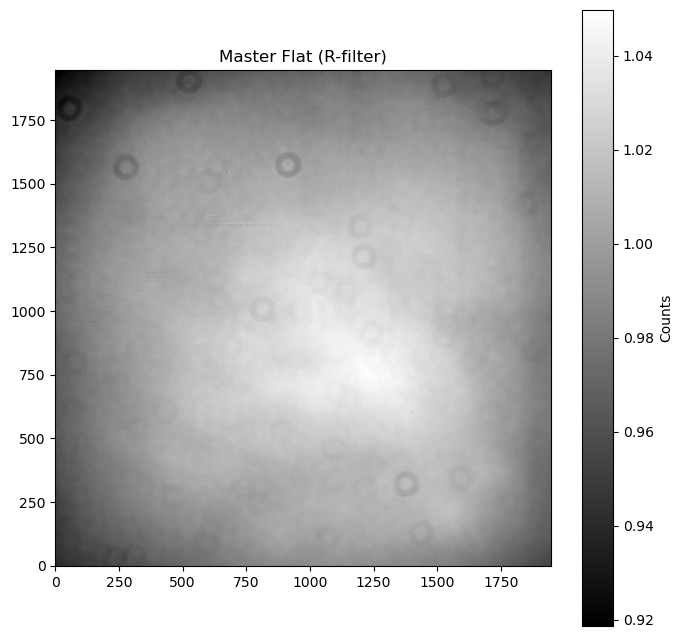

Master Flat (V-filter): min=0.6, max=1.8, median=1.0
Display range (ZScale): 0.9 to 1.0


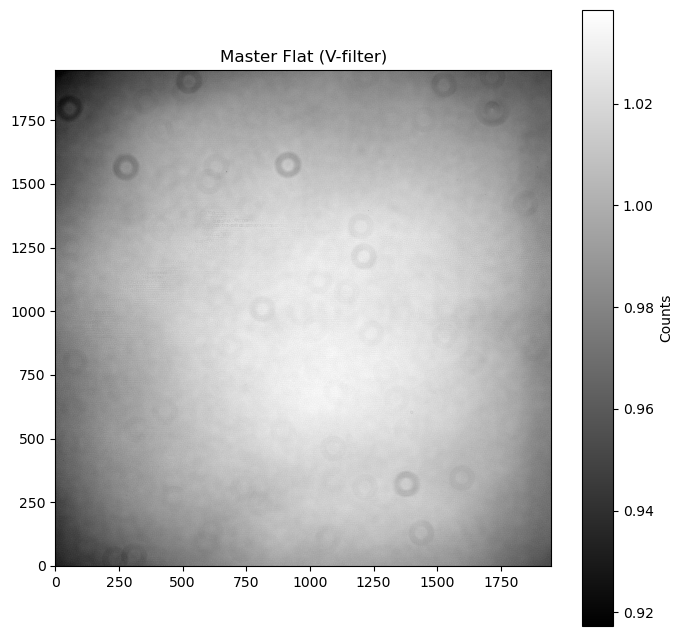

In [6]:
flat_files = sorted(glob.glob(os.path.join(FLAT_DIR, "*.fits")))

# Extracting filter names, e.g. "R" from "2025_10_09_R_flat_01.fits"
filters = sorted(set([os.path.basename(f).split("_")[3] for f in flat_files]))
print("Detected filters:", filters)

bias = master_bias

for flt in filters:
    flt_files = [f for f in flat_files if f"_{flt}_" in f]
    flats = [(fits.getdata(f)[trim:-trim, trim:-trim] - bias) for f in flt_files]
    flats_norm = [f / np.mean(f) for f in flats]
    master_flat = np.median(np.stack(flats_norm), axis=0)
    master_flat /= np.mean(master_flat)
    
    out_path = os.path.join(MASTER_DIR, f"master_flat_{flt}.fits")
    fits.writeto(out_path, master_flat, overwrite=True)

    show_fits(master_flat, f"Master Flat ({flt}-filter)")


In [4]:
# === TRANSIT FILES REDUCTION STEPS ===

master_bias = fits.getdata(os.path.join(MASTER_DIR, "master_bias.fits"))
# Choose appropriate filter manually for now
flt = "R"
master_flat = fits.getdata(os.path.join(MASTER_DIR, f"master_flat_{flt}.fits"))

science_files = sorted(glob.glob(os.path.join(TRANSIT_DIR, "*.fits")))

for i, f in enumerate(science_files, start=1):
    data, hdr = fits.getdata(f, header=True)
    data = data[trim:-trim, trim:-trim]  # trim science frame
    reduced = (data - master_bias) / master_flat
    reduced /= hdr.get('EXPTIME', 1) # Exposure time normalisation

    reduced = reduced.astype(np.float32)  # can actually output files now

    # Create standardized output filename with sequential numbering
    out_filename = f"PIRATE_{i}_OSL_ROE_EXO1_WASP135b_Filter_{flt}.fits"
    out_path = os.path.join(OUTPUT_TRANSIT, out_filename)
    
    fits.writeto(out_path, reduced, hdr, overwrite=True)
    print(f"Reduced: {os.path.basename(f)} -> {out_filename}")

In [8]:
# === STANDARD STARS REDUCTION STEPS ===

master_bias = fits.getdata(os.path.join(MASTER_DIR, "master_bias.fits"))

# Prompt user for filter
flt = "B"
master_flat = fits.getdata(os.path.join(MASTER_DIR, f"master_flat_{flt}.fits"))

science_files = sorted(glob.glob(os.path.join(STANDARDS_DIR, f"*Filter_{flt}*.fits")))

print(f"Found {len(science_files)} files for filter {flt}")

for i, f in enumerate(science_files, start=1):
    data, hdr = fits.getdata(f, header=True)
    data = data[trim:-trim, trim:-trim]  # trim science frame
    reduced = (data - master_bias) / master_flat
    reduced /= hdr.get('EXPTIME', 1) # Exposure time normalisation

    reduced = reduced.astype(np.float32)  # Save space

    # Keep original filename for now
    out_filename = os.path.basename(f)
    out_path = os.path.join(OUTPUT_STANDARDS, out_filename)

    fits.writeto(out_path, reduced, hdr, overwrite=True)
    print(f"Reduced: {os.path.basename(f)} -> {out_filename}")

print(f"\nAll {len(science_files)} standard star files for filter {flt} reduced to {OUTPUT_STANDARDS}")

Found 38 files for filter B
Reduced: PIRATE_164614_OSL_ROE_EXO1_SA111_1965_star1_00_SA111_1965_00_Filter_B_00_2025_10_06_19_38_43.fits -> PIRATE_164614_OSL_ROE_EXO1_SA111_1965_star1_00_SA111_1965_00_Filter_B_00_2025_10_06_19_38_43.fits
Reduced: PIRATE_164615_OSL_ROE_EXO1_SA111_1965_star1_00_SA111_1965_00_Filter_B_01_2025_10_06_19_39_00.fits -> PIRATE_164615_OSL_ROE_EXO1_SA111_1965_star1_00_SA111_1965_00_Filter_B_01_2025_10_06_19_39_00.fits
Reduced: PIRATE_164616_OSL_ROE_EXO1_SA111_1965_star1_00_SA111_1965_00_Filter_B_02_2025_10_06_19_39_17.fits -> PIRATE_164616_OSL_ROE_EXO1_SA111_1965_star1_00_SA111_1965_00_Filter_B_02_2025_10_06_19_39_17.fits
Reduced: PIRATE_164626_OSL_ROE_EXO1_SA111_1965_star1_00_SA111_1965_00_Filter_B_00_2025_10_06_19_51_48.fits -> PIRATE_164626_OSL_ROE_EXO1_SA111_1965_star1_00_SA111_1965_00_Filter_B_00_2025_10_06_19_51_48.fits
Reduced: PIRATE_164627_OSL_ROE_EXO1_SA111_1965_star1_00_SA111_1965_00_Filter_B_01_2025_10_06_19_52_50.fits -> PIRATE_164627_OSL_ROE_EXO1_SA1